 ![FREYA Logo](https://github.com/datacite/pidgraph-notebooks-python/blob/master/images/freya_200x121.png?raw=true) | [FREYA](https://www.project-freya.eu/en) WP2 [User Story 5](https://github.com/datacite/freya/issues/35) | As a student using the British Library's EThOS database, I want to be able to find all dissertations on a given topic.  
 :------------- | :------------- | :-------------

It is important for postgraduate students to identify easily existing dissertations on a research topic of interest.<p />
This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to retrieve all dissertations for three different queries: *Shakespeare*, *Machine learning* and *Ebola*. These queries illustrate trends in the number of dissertations created over time.

**Goal**: By the end of this notebook you should be able to:
- Retrieve all dissertations (across multiple repositories) matching a specific query; 
- For each query:
 - Display a bar plot of the number of dissertations per year, including a trend line, e.g. <br> <img src="example_plot.png" width="290" height="163" />
 - Display a pie chart showing the number of dissertations per repository;
 - Display a word cloud of words from dissertation titles and descriptions, e.g. <br> <img src="example_plot1.png" width="220" height="216" />
 - Download all dissertations in a single BibTeX file.

## Install libraries and prepare GraphQL client

In [ ]:
%%capture
# Install required Python packages
!pip install gql requests sklearn wordcloud numpy pandas

In [1]:
# Prepare the GraphQL client
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)

client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

## Define and run GraphQL query
Define the GraphQL query to retrieve all dissertations using three different queries (that yield distinct trends in number of dissertations across time): *shakespeare*, *Machine learning* and *ebola*.

In [2]:
# Define the GraphQL query: retrieve all dissertations for three different queries: 
# Shakespeare, Machine learning and Ebola.
query_params = {
    "query1" : "shakespeare",
    "query2" : "Machine learning",
    "query3" : "ebola",
    "query1_end_cursor" : "",
    "query2_end_cursor" : "",
    "query3_end_cursor" : "",
    "max_dissertations" : 100
}

queryStr = """query getDissertationsByQuery(
    $query1: String!,
    $query2: String!,
    $query3: String!,
    $query1_end_cursor: String!,
    $query2_end_cursor: String!,
    $query3_end_cursor: String!,
    $max_dissertations: Int!
    )
{
  query1: dissertations(query: $query1, first: $max_dissertations, after: $query1_end_cursor) {
    totalCount
    pageInfo {
      hasNextPage
      endCursor
    }    
    published {
      count
      title
    }
    nodes {
      id
      titles {
        title
      }
      descriptions {
         description
      }
      repository {
        name
      }
      versionOfCount
      identifiers {
        identifier
      }
      publicationYear
      bibtex
      repository {
        id
      }
      publisher
      creators {
        id
        name
      }
    }
  },  
  query2: dissertations(query: $query2, first: $max_dissertations, after: $query2_end_cursor) {
    totalCount
    pageInfo {
      hasNextPage
      endCursor
    }     
    published {
      count
      title
    }
    nodes {
      id
      titles {
        title
      }
      descriptions {
         description
      }
      repository {
        name
      }      
      versionOfCount
      identifiers {
        identifier
      }
      publicationYear
      bibtex
      repository {
        id
      }
      publisher
      creators {
        id
        name
      }
    }
  },
  query3: dissertations(query: $query3, first: $max_dissertations, after: $query3_end_cursor) {
    totalCount
    pageInfo {
      hasNextPage
      endCursor
    }     
    published {
      count
      title
    }
    nodes {
      id
      titles {
        title
      }
      descriptions {
         description
      }
      repository {
        name
      }      
      versionOfCount
      bibtex
      identifiers {
        identifier
      }
      publicationYear
      repository {
        id
      }
      publisher
      creators {
        id
        name
      }
    }
  }
}
"""


Run the above query via the GraphQL client.

In [ ]:
import json
found_next_page = True

# queries_with_more_results controls data for which query still needs to be collected from retrieved results
queries_with_more_results = ['query1', 'query2', 'query3']
# Initialise overall data dict that will store results across all queries
data = {}

# Keep retrieving results until there are no more results left for any of the three queries
while len(queries_with_more_results) > 0:
    print('HEYYYYYYYYYYYYY')
    query = gql("%s" % queryStr)
    res = client.execute(query, variable_values=json.dumps(query_params))
    for query in queries_with_more_results:
        if query not in data:
            data[query] = res[query]
        else:
            data[query]["nodes"].extend(res[query]["nodes"])
        
    for query in ['query1', 'query2', 'query3']:
        if query not in queries_with_more_results:
            continue
        cursor_params_key = query + "_end_cursor"        
        dissertations = res[query]
        pageInfo = dissertations["pageInfo"]
        if pageInfo["hasNextPage"]:
            if pageInfo["endCursor"] is not None:
                query_params[cursor_params_key] = pageInfo["endCursor"]            
            else:
                query_params[cursor_params_key] = ""
                queries_with_more_results.remove(query)
        else:
            query_params[cursor_params_key] = ""
            queries_with_more_results.remove(query)

## Display total number of dissertations
For each query, display the total number of dissertations.

In [5]:
# Get the total number of dissertations per query
for query in ['query1', 'query2', 'query3']:
    print("The total number of dissertations for query '%s':\n%s" % (query_params[query], str(data[query]['totalCount'])))

The total number of dissertations for query 'shakespeare':
133
The total number of dissertations for query 'Machine learning':
1940
The total number of dissertations for query 'ebola':
59


## Plot number of dissertations per year
For each query, display a bar plot of number of dissertations per year, between *start_year* and *end_year* defined in code below. Also shown is a trend line, highlighting the general direction of change in dissertation numbers between *start_year* and *end_year*.

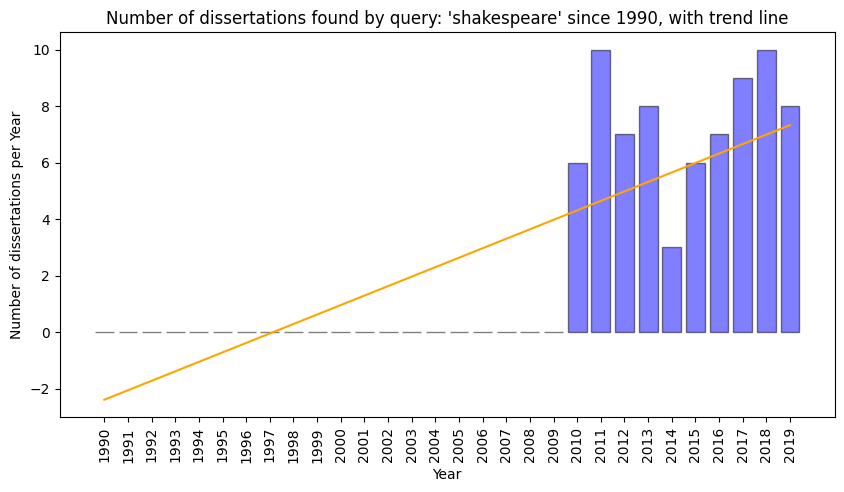

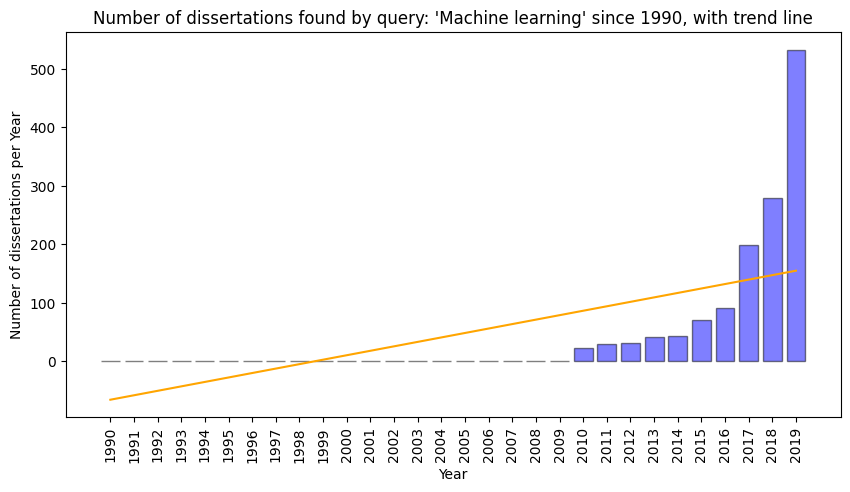

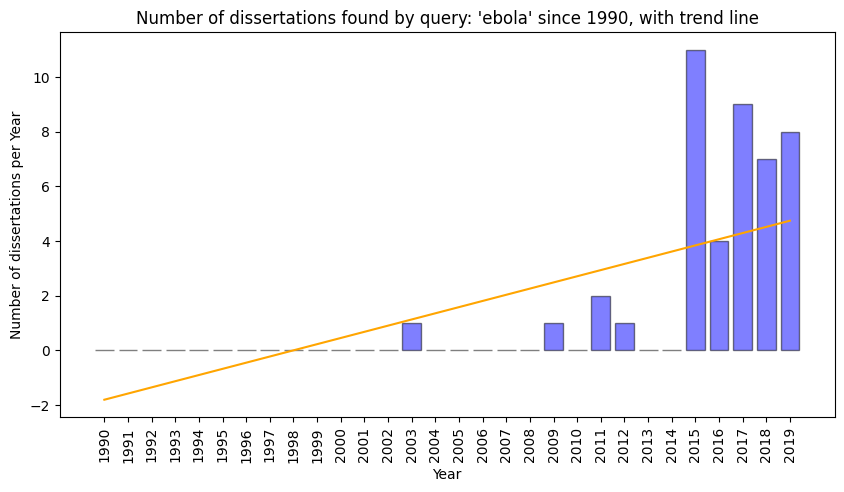

In [6]:
# Plot the number of dissertations by year
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge

start_year = 1990
end_year = 2020
for query in ['query1', 'query2', 'query3']:
    dissertations = data[query]
    queryName = query_params[query]
    plt.rcdefaults()
    years = [int(s['title']) for s in dissertations['published']]
    num_outputs4years = [s['count'] for s in dissertations['published']]
    # Get a list of all consecutive years between min and max year (inclusive)
    all_years = list(range(start_year, end_year))
    # Populate output counts (into num_counts) for all consecutive years
    num_outputs = []
    for year in all_years:
        if year in years:
            idx = years.index(year)
            num_outputs.append(num_outputs4years[idx])
        else:
            num_outputs.append(0)     

    df = pd.DataFrame({'Year': all_years, 'Count': num_outputs} )
    # Create trend line for the plot     
    lr = Ridge()
    lr.fit(df[['Year']], df['Count'])

    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    ax.bar(df['Year'],  df['Count'], align='center', color='blue', edgecolor='black', linewidth=1, alpha=0.5)
    ax.set_xticks(df['Year'])
    ax.set_xticklabels(all_years, rotation='vertical')
    ax.set_ylabel('Number of dissertations per Year')
    ax.set_xlabel('Year')
    ax.set_title("Number of dissertations found by query: '%s' since %s, with trend line" % (query_params[query], str(start_year)))
    ax.plot(df['Year'], lr.coef_*df['Year']+lr.intercept_, color='orange')
    plt.show()


## Plot number of dissertations per repository
For each query, display a pie chart showing the number of dissertations per repository.

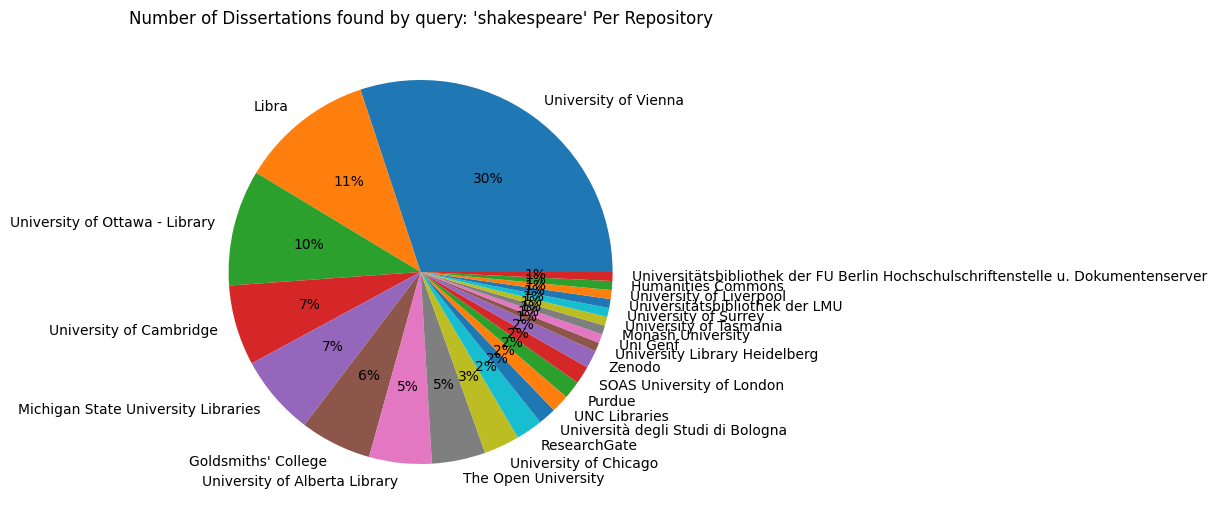

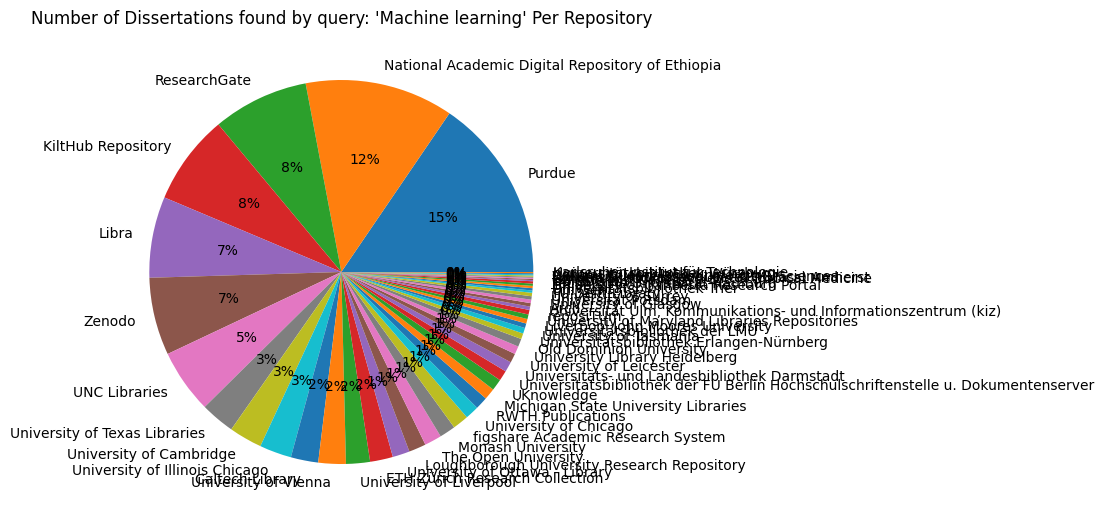

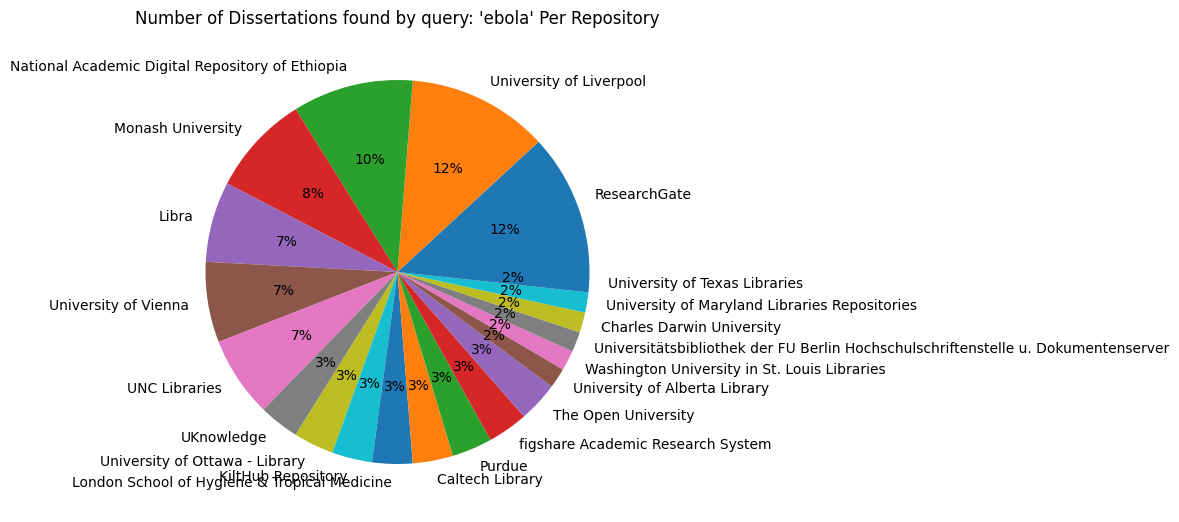

In [7]:
# Plot a pie chart of dissertation counts per repository
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import operator

for query in ['query1', 'query2', 'query3']:
# for query in ['query1']:
    num_outputs_dict = {}
    dissertations = data[query]
    for r in dissertations['nodes']:
        repo = r['repository']['name']
        if repo not in num_outputs_dict:
            num_outputs_dict[repo] = 0
        num_outputs_dict[repo] += 1
    
    # Sort resource types by count of work desc
    sorted_num_outputs = sorted(num_outputs_dict.items(),key=operator.itemgetter(1),reverse=True)
    # Populate lists needed for pie chart
    repositories = [s[0] for s in sorted_num_outputs] 
    num_outputs = [s[1] for s in sorted_num_outputs] 

    # Generate a pie chart of number of grant outputs by resource type
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title("Number of Dissertations found by query: '%s' Per Repository" % query_params[query])
    ax.axis('equal')
    ax.pie(num_outputs, labels = repositories, autopct='%1.0f%%')
    plt.show()
        

## Display a word cloud of dissertation titles and descriptions
For each query, display a wordcloud of words in dissertation titles and descriptions

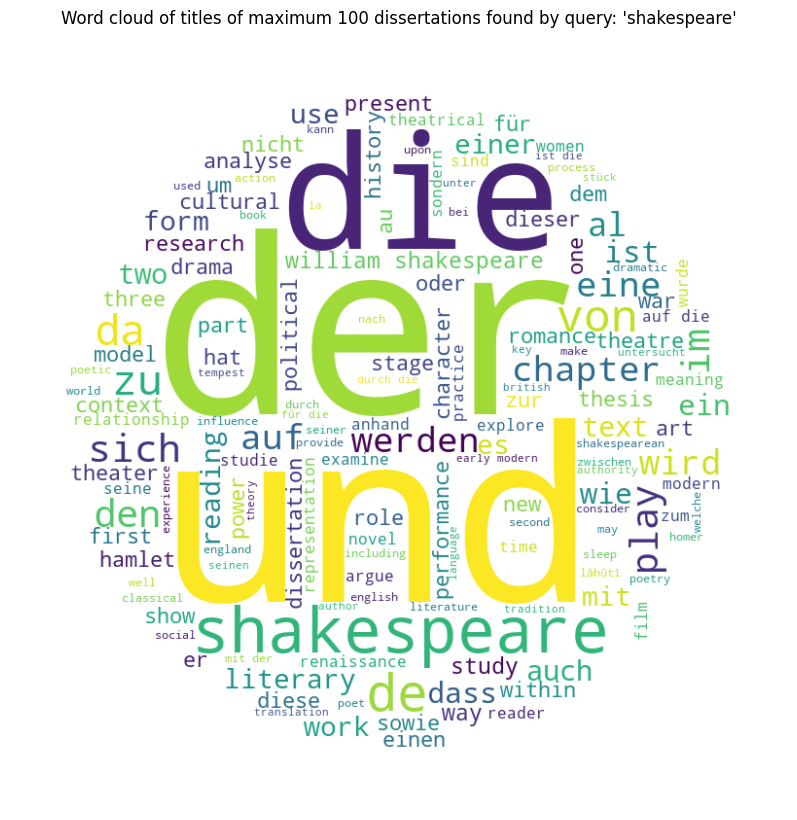

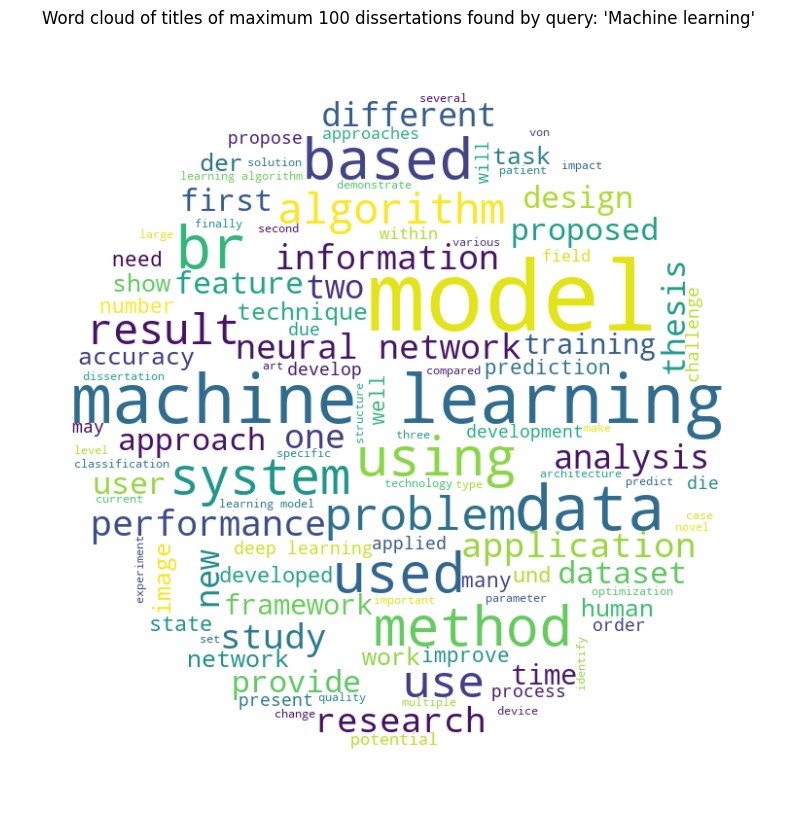

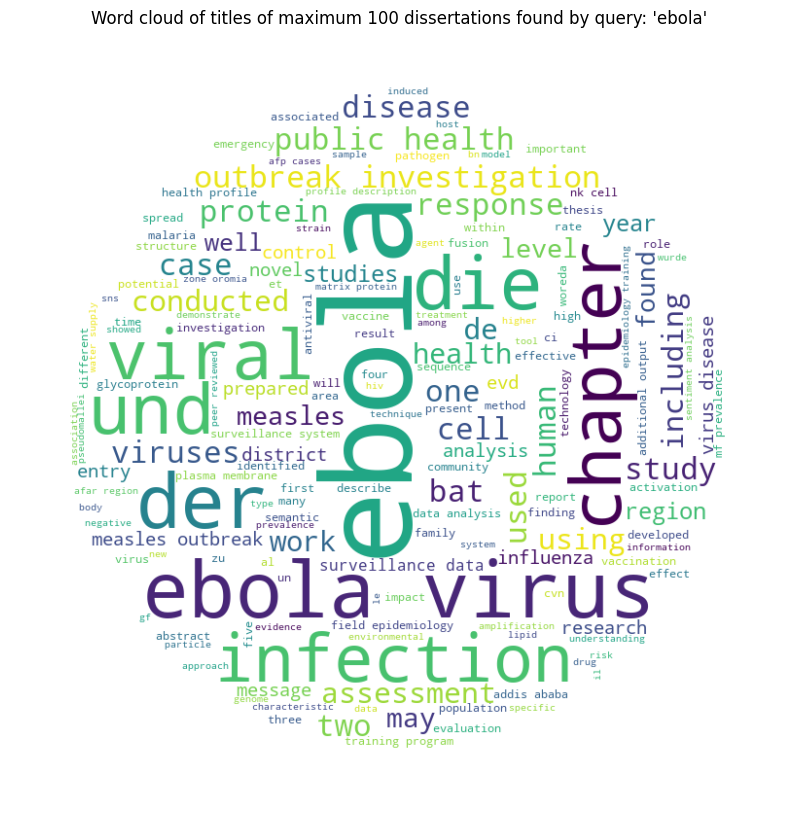

In [8]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd

stopWords = set(STOPWORDS)
stopWords.add('_')

for query in ['query1', 'query2', 'query3']:
    titleWords=[]
    dissertations = data[query]
    for r in dissertations['nodes']:
        for title in r['titles']:
            tokens = [t.lower() for t in str(title['title']).split()] 
        for title in r['descriptions']:
            tokens = [t.lower() for t in str(title['description']).split()]     
        titleWords += tokens
     
    x, y = np.ogrid[:800, :800]
    mask = (x - 400) ** 2 + (y - 400) ** 2 > 345 ** 2
    mask = 255 * mask.astype(int)
    
    wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopWords, 
                min_font_size = 10, 
                mask = mask).generate(" ".join(titleWords))
    
    fig, ax = plt.subplots(1, 1, figsize = (8, 8), facecolor = None)
    ax.set_title("Word cloud of titles of maximum %d dissertations found by query: '%s'" % (query_params['max_dissertations'],query_params[query]))
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.tight_layout(pad = 0)
    plt.show()

## Download file of dissertation entries in BibTeX format
For each query, download a file of dissertation entries in BibTeX format.

In [9]:
import pandas as pd
from IPython.display import Javascript
from requests.utils import requote_uri

# For each query, download a file containing BibTeX entries of all dissertations
for query in ['query1', 'query2', 'query3']:    
    dissertations = data[query]
    bibtex_data = []
    for r in dissertations['nodes']:
        bibtex_data.append([r['bibtex']])
    df = pd.DataFrame(bibtex_data, columns = None)

    js_download = """
var csv = '%s';

var filename = '%s.bib';
var blob = new Blob([csv], { type: 'application/x-bibtex;charset=utf-8;' });
if (navigator.msSaveBlob) { // IE 10+
    navigator.msSaveBlob(blob, filename);
} else {
    var link = document.createElement("a");
    if (link.download !== undefined) { // feature detection
        // Browsers that support HTML5 download attribute
        var url = URL.createObjectURL(blob);
        link.setAttribute("href", url);
        link.setAttribute("download", filename);
        link.style.visibility = 'hidden';
        document.body.appendChild(link);
        link.click();
        document.body.removeChild(link);
    }
}
""" % (df.to_csv(index=False, header=False).replace('\n','\\n').replace("\'","\\'").replace("\"","").replace("\r",""), requote_uri(query_params[query]))
    
#     display(Javascript(js_download))